In [71]:
!pip install pandas
!pip install numpy

In [72]:
!pip install obspy

In [73]:
!pip install matplotlib
!pip install obspy

In [1]:
# Import libraries
import numpy as np
import pandas as pd

from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import os

from obspy import read
from sklearn.preprocessing import StandardScaler
from scipy import signal

# Loop through each file
from sklearn.svm import OneClassSVM
from keras.models import Model
from keras.layers import Input, Dense

In [2]:
directory_path = 'data/mars/training/data/'

# Lists to hold file names
csv_files = []
mseed_files = []

# Walk through the directory
for root, dirs, files in os.walk(directory_path):
    for file in files:
        if file.endswith(".csv"):
            csv_files.append(file)
        elif file.endswith(".mseed"):
            mseed_files.append(file)

# Output the lists
print("CSV Files:", csv_files)
print("MSEED Files:", mseed_files)

CSV Files: ['XB.ELYSE.02.BHV.2022-02-03HR08_evid0005.csv', 'XB.ELYSE.02.BHV.2022-01-02HR04_evid0006.csv']
MSEED Files: ['XB.ELYSE.02.BHV.2022-02-03HR08_evid0005.mseed', 'XB.ELYSE.02.BHV.2022-01-02HR04_evid0006.mseed']


In [90]:
!pip install keras

Epoch 1/5


2024-10-05 22:02:38.294264: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-10-05 22:02:38.294292: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-10-05 22:02:38.294300: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-10-05 22:02:38.294320: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-10-05 22:02:38.294336: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2024-10-05 22:02:38.699481: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


2250/2250 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - loss: 0.8348
Epoch 2/5
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 0.6833
Epoch 3/5
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 0.7149
Epoch 4/5
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 0.6653
Epoch 5/5
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 0.6837
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 2s 939us/step


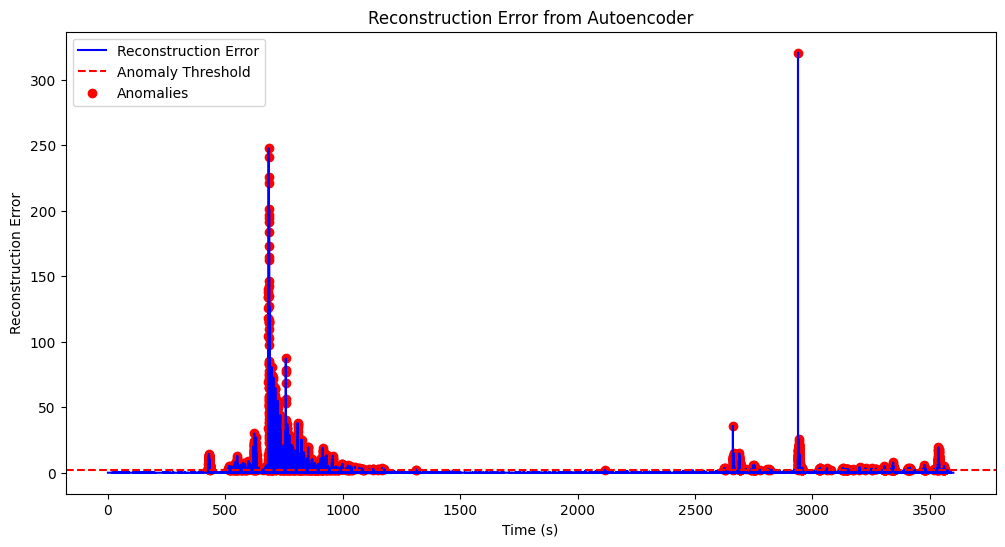

Epoch 1/5
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - loss: 0.8031
Epoch 2/5
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 0.6299
Epoch 3/5
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 0.6395
Epoch 4/5
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 0.6431
Epoch 5/5
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 0.6542
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 2s 926us/step


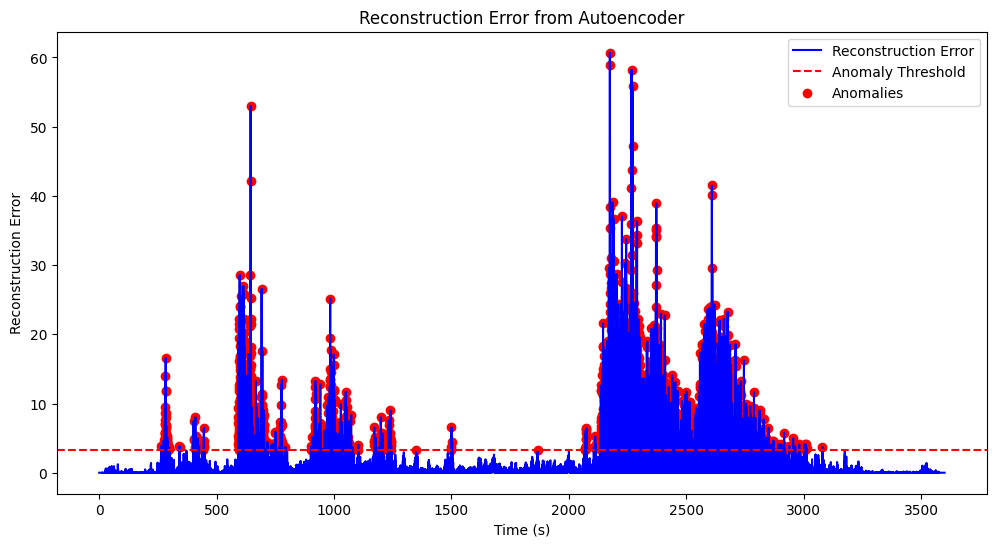

In [3]:
# Loop through each CSV and MiniSEED file
for csv_file, mseed_file in zip(csv_files, mseed_files):
    # Load the CSV file with time and velocity data
    csv_data = pd.read_csv(directory_path + csv_file)
    
        # Extract time and velocity from the CSV
    rel_time = csv_data['rel_time(sec)'].values  # Relative time in seconds
    velocity = csv_data['velocity(c/s)'].values

    # Load the MiniSEED file for frequency and seismic data
    st = read(directory_path + mseed_file)

    # Get the trace and relevant information from MiniSEED file
    trace = st[0]  # Assuming you're working with a single trace
    data = trace.data

    # Normalize the data (important for neural networks)
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data.reshape(-1, 1))  # Reshape for scaler

    # Split data into normal and anomalous for training (if you have labeled data)
    # For demonstration, assume we use all data as normal for training
    normal_data = data_scaled  # Use only normal data for training

    # Define the Autoencoder architecture
    input_dim = normal_data.shape[1]  # Number of features
    encoding_dim = 32  # Dimension of the encoding layer

    # Input layer
    input_layer = Input(shape=(input_dim,))
    # Encoder layer
    encoder = Dense(encoding_dim, activation='relu')(input_layer)
    # Decoder layer
    decoder = Dense(input_dim, activation='sigmoid')(encoder)

    # Autoencoder model
    autoencoder = Model(input_layer, decoder)
    autoencoder.compile(optimizer='adam', loss='mean_squared_error')

    # Train the Autoencoder
    autoencoder.fit(normal_data, normal_data, epochs=5, batch_size=32, shuffle=True)

    # Use the Autoencoder to reconstruct the data
    reconstructed_data = autoencoder.predict(data_scaled)

    # Calculate reconstruction error
    reconstruction_error = np.mean(np.square(reconstructed_data - data_scaled), axis=1)

    # Set a threshold for anomaly detection (you might want to tune this)
    threshold = np.percentile(reconstruction_error, 95)  # For example, top 5% as anomalies

    # Identify anomalies
    anomalies = reconstruction_error > threshold

    # Plot the reconstruction error
    plt.figure(figsize=(12, 6))
    plt.plot(rel_time, reconstruction_error, label='Reconstruction Error', color='blue')
    plt.axhline(y=threshold, color='red', linestyle='--', label='Anomaly Threshold')
    plt.scatter(rel_time[anomalies], reconstruction_error[anomalies], color='red', label='Anomalies')
    plt.xlabel('Time (s)')
    plt.ylabel('Reconstruction Error')
    plt.title('Reconstruction Error from Autoencoder')
    plt.legend()
    plt.show()

2250/2250 ━━━━━━━━━━━━━━━━━━━━ 2s 989us/step
Arrival time of the anomaly near maximum error: 2170.25


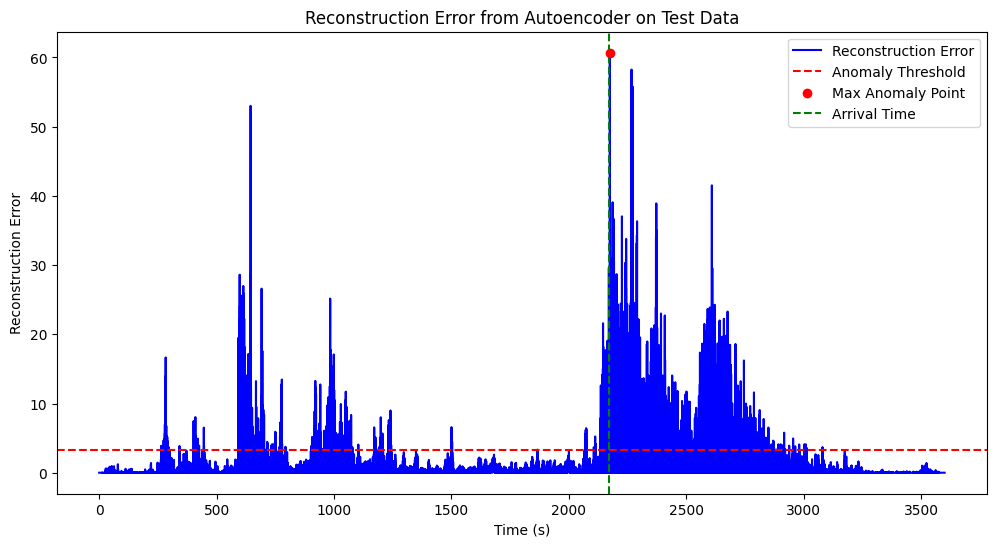

In [5]:

# Load the test CSV file with time and velocity data
test_csv_file = "data/mars/training/data/XB.ELYSE.02.BHV.2022-01-02HR04_evid0006.csv"
test_csv_data = pd.read_csv(test_csv_file)

# Extract time and velocity from the test CSV
test_rel_time = test_csv_data['rel_time(sec)'].values  # Relative time in seconds
test_velocity = test_csv_data['velocity(c/s)'].values

# Load the test MiniSEED file for frequency and seismic data
test_mseed_file = "data/mars/training/data/XB.ELYSE.02.BHV.2022-01-02HR04_evid0006.mseed"
test_st = read(test_mseed_file)

# Get the trace and relevant information from the test MiniSEED file
test_trace = test_st[0]  # Assuming you're working with a single trace
test_data = test_trace.data

# Normalize the test data using the same scaler used for training
scaler = StandardScaler()
test_data_scaled = scaler.fit_transform(test_data.reshape(-1, 1))  # Reshape for scaler

# Use the Autoencoder to reconstruct the test data
reconstructed_test_data = autoencoder.predict(test_data_scaled)

# Calculate reconstruction error for the test data
reconstruction_error_test = np.mean(np.square(reconstructed_test_data - test_data_scaled), axis=1)

# Set a threshold for anomaly detection (calculate this threshold)
threshold_test = np.percentile(reconstruction_error_test, 95)  # Top 5% as anomalies

# Identify the maximum reconstruction error and its index
max_error_index = np.argmax(reconstruction_error_test)
max_reconstruction_error = reconstruction_error_test[max_error_index]

# Get the corresponding time for the maximum reconstruction error
max_error_time = test_rel_time[max_error_index]

# Define a search window (in seconds) around the max_error_time
search_window = 5  # Adjust this value based on your data characteristics
start_time = max(0, max_error_time - search_window)  # Prevent underflow
end_time = min(max(test_rel_time), max_error_time + search_window)  # Prevent overflow

# Identify nearby anomalies within the search window
nearby_anomalies = (test_rel_time >= start_time) & (test_rel_time <= end_time)
nearby_error_values = reconstruction_error_test[nearby_anomalies]

# Check if there are any anomalies in the nearby errors
if nearby_error_values.size > 0:
    # Find the first anomaly within the search window
    first_anomaly_index = np.argmax(nearby_error_values > threshold_test)  # Use the calculated threshold

    if first_anomaly_index < nearby_error_values.size and nearby_error_values[first_anomaly_index] > threshold_test:
        # Get the arrival time of the detected anomaly
        arrival_time = test_rel_time[np.where(nearby_anomalies)[0][first_anomaly_index]]
        print(f"Arrival time of the anomaly near maximum error: {arrival_time}")
    else:
        print("No nearby anomalies detected within the search window.")
else:
    print("No nearby errors detected within the search window.")

# Optional: Plot the reconstruction error and mark the arrival time
plt.figure(figsize=(12, 6))
plt.plot(test_rel_time, reconstruction_error_test, label='Reconstruction Error', color='blue')
plt.axhline(y=threshold_test, color='red', linestyle='--', label='Anomaly Threshold')
plt.scatter(max_error_time, max_reconstruction_error, color='red', label='Max Anomaly Point', zorder=5)

# Highlight the arrival time if detected
if 'arrival_time' in locals():
    plt.axvline(x=arrival_time, color='green', linestyle='--', label='Arrival Time')

plt.xlabel('Time (s)')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction Error from Autoencoder on Test Data')
plt.legend()
plt.show()

In [13]:

# Load the test CSV file with time and velocity data
test_csv_file = "data/mars/training/data/XB.ELYSE.02.BHV.2022-01-02HR04_evid0006.csv"
test_csv_data = pd.read_csv(test_csv_file)

# Extract time and velocity from the test CSV
test_rel_time = test_csv_data['rel_time(sec)'].values  # Relative time in seconds
test_velocity = test_csv_data['velocity(c/s)'].values

# Load the test MiniSEED file for frequency and seismic data
test_mseed_file = "data/mars/training/data/XB.ELYSE.02.BHV.2022-01-02HR04_evid0006.mseed"
test_st = read(test_mseed_file)

# Get the trace and relevant information from the test MiniSEED file
test_trace = test_st[0]  # Assuming single trace
test_data = test_trace.data
sampling_rate = test_trace.stats.sampling_rate  # Sampling rate for spectrogram

# Normalize the test data using the same scaler used for training
scaler = StandardScaler()
test_data_scaled = scaler.fit_transform(test_data.reshape(-1, 1))

# Use the Autoencoder to reconstruct the test data
reconstructed_test_data = autoencoder.predict(test_data_scaled)

# Calculate reconstruction error for the test data
reconstruction_error_test = np.mean(np.square(reconstructed_test_data - test_data_scaled), axis=1)

# Set a threshold for anomaly detection (adjust based on validation)
threshold_test = np.percentile(reconstruction_error_test, 95)  # Top 5% as anomalies

# Identify the maximum reconstruction error and its index
max_error_index = np.argmax(reconstruction_error_test)
max_reconstruction_error = reconstruction_error_test[max_error_index]

# Get the corresponding time for the maximum reconstruction error
max_error_time = test_rel_time[max_error_index]

# Define a search window (in seconds) around the max_error_time
search_window = 50  # Adjust based on data
start_time = max(0, max_error_time - search_window)
end_time = min(max(test_rel_time), max_error_time + search_window)

# Identify nearby anomalies within the search window
nearby_anomalies = (test_rel_time >= start_time) & (test_rel_time <= end_time)
nearby_error_values = reconstruction_error_test[nearby_anomalies]

# Check if there are any anomalies in the nearby errors
arrival_time = None
if nearby_error_values.size > 0:
    first_anomaly_index = np.argmax(nearby_error_values > threshold_test)
    if first_anomaly_index < nearby_error_values.size and nearby_error_values[first_anomaly_index] > threshold_test:
        # Get the arrival time of the detected anomaly
        arrival_time = test_rel_time[np.where(nearby_anomalies)[0][first_anomaly_index]]
        print(f"Arrival time of the anomaly near maximum error: {arrival_time}")
    else:
        print("No nearby anomalies detected within the search window.")
else:
    print("No nearby errors detected within the search window.")

# Plot the reconstruction error and mark the arrival time
plt.figure(figsize=(12, 6))
plt.plot(test_rel_time, reconstruction_error_test, label='Reconstruction Error', color='blue')
plt.axhline(y=max_reconstruction_error, color='red', linestyle='--', label='Max Error Threshold')
plt.scatter(max_error_time, max_reconstruction_error, color='red', label='Max Anomaly Point', zorder=5)

# Highlight the arrival time if detected
if arrival_time:
    plt.axvline(x=arrival_time, color='green', linestyle='--', label='Arrival Time')

plt.xlabel('Time (s)')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction Error from Autoencoder on Test Data')
plt.legend()
plt.show()

# Plot the time series and the spectrogram together

# Filtered velocity data
tr_times_filt = test_rel_time
tr_data_filt = test_velocity

# Spectrogram calculation
f, t, sxx = spectrogram(test_velocity, fs=sampling_rate)

# Plot the time series and spectrogram
fig = plt.figure(figsize=(10, 10))

# Plot the filtered time series
ax = plt.subplot(2, 1, 1)
ax.plot(tr_times_filt, tr_data_filt, color='blue')

# Mark the anomaly detection (arrival time)
if arrival_time:
    ax.axvline(x=arrival_time, color='red', label='Detection')
ax.legend(loc='upper left')

# Make the plot pretty
ax.set_xlim([min(tr_times_filt), max(tr_times_filt)])
ax.set_ylabel('Velocity (c/s)')
ax.set_xlabel('Time (s)')

# Plot the spectrogram
ax2 = plt.subplot(2, 1, 2)
vals = ax2.pcolormesh(t, f, sxx, cmap=cm.jet, shading='auto')
ax2.set_xlim([min(tr_times_filt), max(tr_times_filt)])
ax2.set_xlabel(f'Time (Day Hour:Minute)', fontweight='bold')
ax2.set_ylabel('Frequency (Hz)', fontweight='bold')

# Mark the anomaly detection (arrival time) on the spectrogram
if arrival_time:
    ax2.axvline(x=arrival_time, color='red')

# Add color bar
cbar = plt.colorbar(vals, orientation='horizontal')
cbar.set_label('Power ((c/s)^2/sqrt(Hz))', fontweight='bold')

plt.tight_layout()
plt.show()

2024-10-05 22:28:09.226271: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: In[0] mismatch In[1] shape: 1 vs. 3: [32,1] [3,32] 0 0
	 [[{{node functional_5_1/dense_10_1/MatMul}}]]


InvalidArgumentError: Graph execution error:

Detected at node functional_5_1/dense_10_1/MatMul defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/opt/anaconda3/envs/MLA/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/opt/anaconda3/envs/MLA/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/opt/anaconda3/envs/MLA/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/opt/anaconda3/envs/MLA/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/opt/anaconda3/envs/MLA/lib/python3.11/asyncio/base_events.py", line 608, in run_forever

  File "/opt/anaconda3/envs/MLA/lib/python3.11/asyncio/base_events.py", line 1936, in _run_once

  File "/opt/anaconda3/envs/MLA/lib/python3.11/asyncio/events.py", line 84, in _run

  File "/opt/anaconda3/envs/MLA/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/opt/anaconda3/envs/MLA/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/opt/anaconda3/envs/MLA/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/opt/anaconda3/envs/MLA/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/opt/anaconda3/envs/MLA/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/opt/anaconda3/envs/MLA/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/opt/anaconda3/envs/MLA/lib/python3.11/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/opt/anaconda3/envs/MLA/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/opt/anaconda3/envs/MLA/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/opt/anaconda3/envs/MLA/lib/python3.11/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/opt/anaconda3/envs/MLA/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/opt/anaconda3/envs/MLA/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/opt/anaconda3/envs/MLA/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/var/folders/0y/_qpkhqy57dd3pfbf16f5k2dm0000gn/T/ipykernel_14635/1122469398.py", line 23, in <module>

  File "/opt/anaconda3/envs/MLA/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/opt/anaconda3/envs/MLA/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 512, in predict

  File "/opt/anaconda3/envs/MLA/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 208, in one_step_on_data_distributed

  File "/opt/anaconda3/envs/MLA/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 198, in one_step_on_data

  File "/opt/anaconda3/envs/MLA/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 96, in predict_step

  File "/opt/anaconda3/envs/MLA/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/opt/anaconda3/envs/MLA/lib/python3.11/site-packages/keras/src/layers/layer.py", line 901, in __call__

  File "/opt/anaconda3/envs/MLA/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/opt/anaconda3/envs/MLA/lib/python3.11/site-packages/keras/src/ops/operation.py", line 46, in __call__

  File "/opt/anaconda3/envs/MLA/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/opt/anaconda3/envs/MLA/lib/python3.11/site-packages/keras/src/models/functional.py", line 175, in call

  File "/opt/anaconda3/envs/MLA/lib/python3.11/site-packages/keras/src/ops/function.py", line 171, in _run_through_graph

  File "/opt/anaconda3/envs/MLA/lib/python3.11/site-packages/keras/src/models/functional.py", line 560, in call

  File "/opt/anaconda3/envs/MLA/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/opt/anaconda3/envs/MLA/lib/python3.11/site-packages/keras/src/layers/layer.py", line 901, in __call__

  File "/opt/anaconda3/envs/MLA/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/opt/anaconda3/envs/MLA/lib/python3.11/site-packages/keras/src/ops/operation.py", line 46, in __call__

  File "/opt/anaconda3/envs/MLA/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/opt/anaconda3/envs/MLA/lib/python3.11/site-packages/keras/src/layers/core/dense.py", line 144, in call

  File "/opt/anaconda3/envs/MLA/lib/python3.11/site-packages/keras/src/ops/numpy.py", line 3445, in matmul

  File "/opt/anaconda3/envs/MLA/lib/python3.11/site-packages/keras/src/backend/tensorflow/numpy.py", line 477, in matmul

In[0] mismatch In[1] shape: 1 vs. 3: [32,1] [3,32] 0 0
	 [[{{node functional_5_1/dense_10_1/MatMul}}]] [Op:__inference_one_step_on_data_distributed_150817]

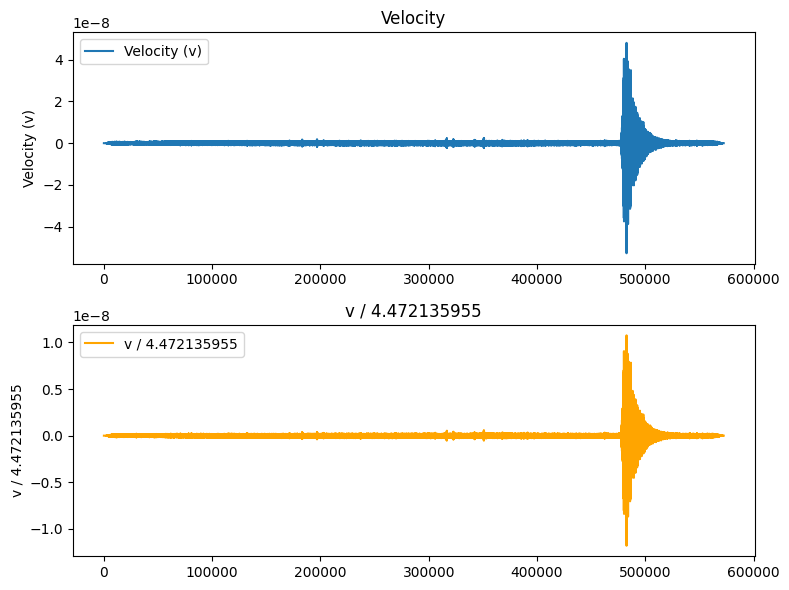

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Let's also get the name of the file
test_filename = row.filename
test_filename
data_directory = './data/lunar/training/data/S12_GradeA/'
csv_file = f'{data_directory}{test_filename}.csv'
data_cat = pd.read_csv(csv_file)
data_cat

# Read in time steps and velocities
csv_times = np.array(data_cat['time_rel(sec)'].tolist())
csv_data = np.array(data_cat['velocity(m/s)'].tolist())

v_div = csv_data / 4.472135955
# Create subplots
fig, axs = plt.(2, 1, figsize=(8, 6))

# Plot velocity
axs[0].plot(csv_data, label='Velocity (v)')
axs[0].set_title('Velocity')
axs[0].set_ylabel('Velocity (v)')
axs[0].legend()

# Plot v divided by 4.472135955
axs[1].plot(v_div, color='orange', label='v / 4.472135955')
axs[1].set_title('v / 4.472135955')

axs[1].set_ylabel('v / 4.472135955')
axs[1].legend()

# Adjust layout
plt.tight_layout()
plt.show()


C:\Users\RAJASHEKHAR\AppData\Local\Temp\ipykernel_4464\765181987.py:46: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
c:\Users\RAJASHEKHAR\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


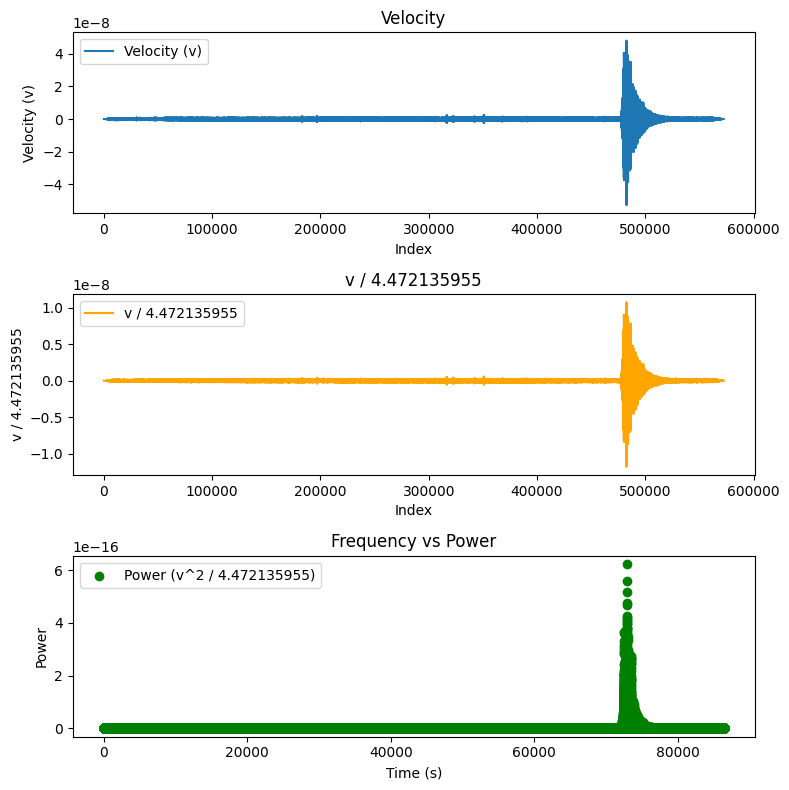

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Assume 'test_filename' is defined
test_filename = row.filename
data_directory = './data/lunar/training/data/S12_GradeA/'
csv_file = f'{data_directory}{test_filename}.csv'
data_cat = pd.read_csv(csv_file)

# Read in time steps and velocities
csv_times = np.array(data_cat['time_rel(sec)'].tolist())
csv_data = np.array(data_cat['velocity(m/s)'].tolist())

# Calculate v divided by 4.472135955
v_div = csv_data / 4.472135955

# Calculate power: (v^2) / 4.472135955
power = (csv_data ** 2) / 4.472135955

# Create subplots
fig, axs = plt.subplots(3, 1, figsize=(8, 8))

# Plot velocity
axs[0].plot(csv_data, label='Velocity (v)')
axs[0].set_title('Velocity')
axs[0].set_xlabel('Index')
axs[0].set_ylabel('Velocity (v)')
axs[0].legend()

# Plot v divided by 4.472135955
axs[1].plot(v_div, color='orange', label='v / 4.472135955')
axs[1].set_title('v / 4.472135955')
axs[1].set_xlabel('Index')
axs[1].set_ylabel('v / 4.472135955')
axs[1].legend()

# Scatter plot of frequency (csv_times) vs power
axs[2].scatter(csv_times, power, color='green', label='Power (v^2 / 4.472135955)')
axs[2].set_title('Frequency vs Power')
axs[2].set_xlabel('Time (s)')
axs[2].set_ylabel('Power')
axs[2].legend()

# Adjust layout
plt.tight_layout()
plt.show()


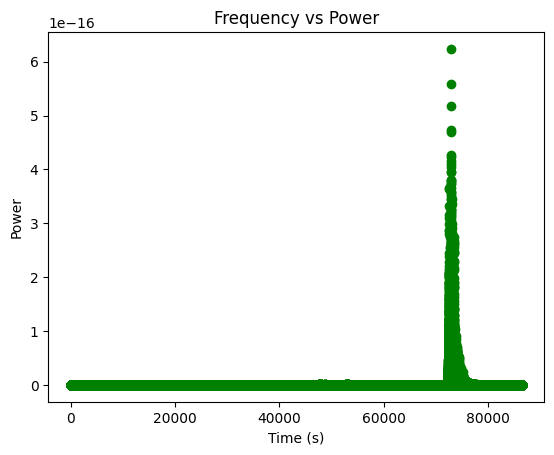

In [24]:


# Read time and velocity data
csv_times = np.array(data_cat['time_rel(sec)'].tolist())  # Frequency (or time)
csv_data = np.array(data_cat['velocity(m/s)'].tolist())   # Velocity

# Calculate power: (velocity^2) / 4.472135955
power = (csv_data ** 2) / 4.472135955

# Create scatter plot of frequency vs power
plt.scatter(csv_times, power, color='green')
plt.title('Frequency vs Power')
plt.xlabel('Time (s)')
plt.ylabel('Power')
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.signal import spectrogram

# Assuming data_cat is your DataFrame and contains columns 'time_rel(sec)' and 'velocity(m/s)'
csv_times = np.array(data_cat['time_rel(sec)'].tolist())  # Relative time in seconds
csv_data = np.array(data_cat['velocity(m/s)'].tolist())   # Velocity in m/s

# Calculate power: (velocity^2) / 4.472135955
power = (csv_data ** 2) / 4.472135955

# Arrival time for detection (assuming you have it, you can set it based on your data)
arrival = np.mean(csv_times)  # Example: using the mean time as arrival (you can set it as needed)

# Time series plot of filtered data (velocity)
fig = plt.figure(figsize=(10, 10))

# Subplot 1: Time series plot
ax = plt.subplot(2, 1, 1)
ax.plot(csv_times, csv_data)

# Mark detection with a red vertical line at arrival time
ax.axvline(x=arrival, color='red', label='Detection')
ax.legend(loc='upper left')

# Make the plot pretty
ax.set_xlim([min(csv_times), max(csv_times)])
ax.set_ylabel('Velocity (m/s)')
ax.set_xlabel('Time (s)')

# Subplot 2: Spectrogram plot
ax2 = plt.subplot(2, 1, 2)

# Calculate the spectrogram
f, t, sxx = spectrogram(csv_data, fs=1/(csv_times[1] - csv_times[0]))  # Sampling frequency derived from time data

# Plot the spectrogram using pcolormesh

vals = ax2.pcolormesh(t, f, sxx, cmap=cm.jet, vmax=5e-17)

# Set axis limits, labels, and format
ax2.set_xlim([min(t), max(t)])
ax2.set_xlabel('Time (s)', fontweight='bold')
ax2.set_ylabel('Frequency (Hz)', fontweight='bold')

# Mark the arrival time on the spectrogram
ax2.axvline(x=arrival, color='red')

# Add a color bar
cbar = plt.colorbar(vals, orientation='horizontal')
cbar.set_label('Power ((m/s)^2/sqrt(Hz))', fontweight='bold')

plt.show()

NEW start

In [8]:
# Import libraries
import numpy as np
import pandas as pd
from obspy import read
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import os

In [61]:
cat_directory = './data/lunar/training/data/'
cat_file = 'data/lunar/test/data/S12_GradeB/xa.s12.00.mhz.1970-05-24HR00_evid00028.csv'
cat = pd.read_csv(cat_file)
cat

,time_abs(%Y-%m-%dT%H:%M:%S.%f),time_rel(sec),velocity(m/s)
0,1970-05-24T00:00:00.668000,0.000000,-4.421151e-14
1,1970-05-24T00:00:00.818943,0.150943,-5.537240e-14
2,1970-05-24T00:00:00.969887,0.301887,-6.035054e-14
3,1970-05-24T00:00:01.120830,0.452830,-5.813846e-14
4,1970-05-24T00:00:01.271774,0.603774,-5.091737e-14
...,...,...,...
572406,1970-05-25T00:00:01.573660,86400.905660,-8.624090e-15
572407,1970-05-25T00:00:01.724604,86401.056604,-1.241975e-14
572408,1970-05-25T00:00:01.875547,86401.207547,-1.475373e-14
572409,1970-05-25T00:00:02.026491,86401.358491,-2.037283e-14


In [62]:
# data_directory = './data/lunar/training/data/S12_GradeA/'
mseed_file = 'data/lunar/test/data/S12_GradeB/xa.s12.00.mhz.1970-05-24HR00_evid00028.mseed'
st = read(mseed_file)
st

1 Trace(s) in Stream:
XA.S12.00.MHZ | 1970-05-24T00:00:00.668000Z - 1970-05-25T00:00:02.177434Z | 6.6 Hz, 572411 samples

In [63]:
# Set the minimum frequency
minfreq = 0.5
maxfreq = 1.0

# Going to create a separate trace for the filter data
st_filt = st.copy()
st_filt.filter('bandpass',freqmin=minfreq,freqmax=maxfreq)
tr_filt = st_filt.traces[0].copy()
tr_times_filt = tr_filt.times()
tr_data_filt = tr_filt.data

In [68]:
# To better see the patterns, we will create a spectrogram using the scipy function
# It requires the sampling rate, which we can get from the miniseed header as shown a few cells above
from scipy import signal
from matplotlib import cm
f, t, sxx = signal.spectrogram(tr_data_filt, tr_filt.stats.sampling_rate)
print(t.size)
print(f.size)
print(sxx.size)
print(sxx.shape)
# df = cat.copy()
# df['timefrom_mseed'] = t
# f['frequency'] = f
# df['sxx_value'] = sxx



2555
129
329595
(129, 2555)


In [76]:

for i in range(t.size):
    print(t[i])



19.32075471698113
53.132075471698116
86.94339622641509
120.75471698113208
154.56603773584905
188.37735849056602
222.18867924528303
256.0
289.811320754717
323.62264150943395
357.4339622641509
391.24528301886795
425.0566037735849
458.8679245283019
492.6792452830189
526.4905660377359
560.3018867924528
594.1132075471698
627.9245283018868
661.7358490566038
695.5471698113207
729.3584905660377
763.1698113207547
796.9811320754717
830.7924528301887
864.6037735849056
898.4150943396227
932.2264150943396
966.0377358490566
999.8490566037735
1033.6603773584907
1067.4716981132076
1101.2830188679245
1135.0943396226414
1168.9056603773586
1202.7169811320755
1236.5283018867924
1270.3396226415093
1304.1509433962265
1337.9622641509434
1371.7735849056603
1405.5849056603774
1439.3962264150944
1473.2075471698113
1507.0188679245282
1540.8301886792453
1574.6415094339623
1608.4528301886792
1642.2641509433963
1676.0754716981132
1709.8867924528302
1743.698113207547
1777.5094339622642
1811.3207547169811
1845.132075

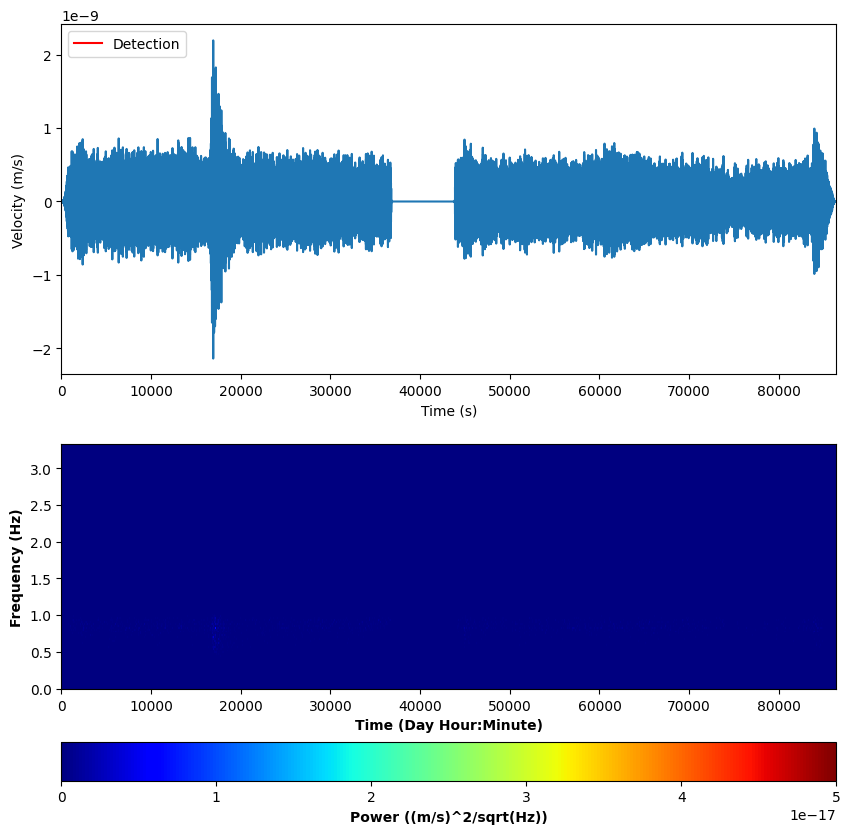

In [65]:
# Plot the time series and spectrogram
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(2, 1, 1)
# Plot trace
ax.plot(tr_times_filt,tr_data_filt)

# Mark detection
ax.axvline(x = arrival, color='red',label='Detection')
ax.legend(loc='upper left')

# Make the plot pretty
ax.set_xlim([min(tr_times_filt),max(tr_times_filt)])
ax.set_ylabel('Velocity (m/s)')
ax.set_xlabel('Time (s)')

ax2 = plt.subplot(2, 1, 2)
vals = ax2.pcolormesh(t, f, sxx, cmap=cm.jet, vmax=5e-17)
ax2.set_xlim([min(tr_times_filt),max(tr_times_filt)])
ax2.set_xlabel(f'Time (Day Hour:Minute)', fontweight='bold')
ax2.set_ylabel('Frequency (Hz)', fontweight='bold')
ax2.axvline(x=arrival, c='red')
cbar = plt.colorbar(vals, orientation='horizontal')
cbar.set_label('Power ((m/s)^2/sqrt(Hz))', fontweight='bold')

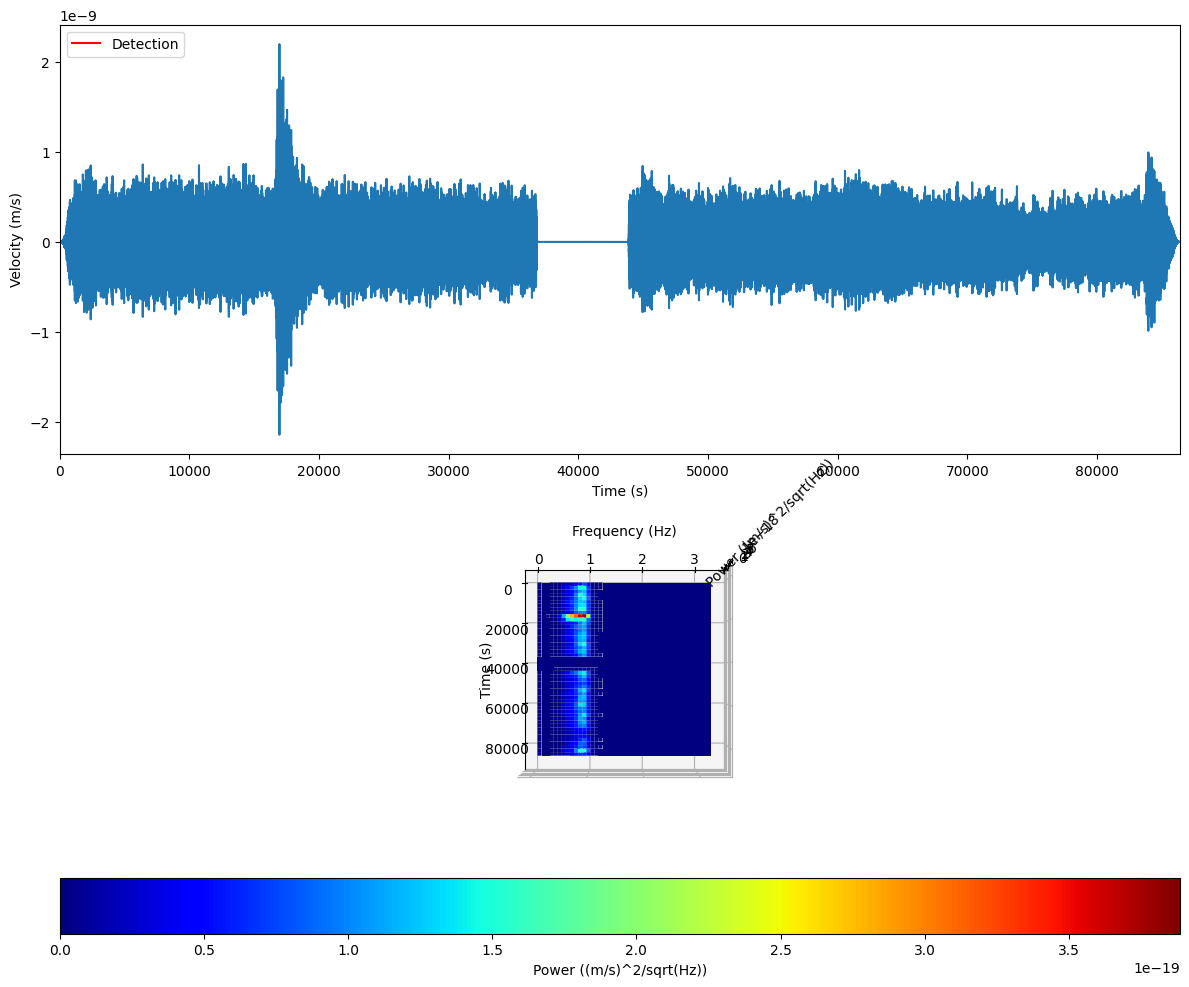

In [67]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

# Create the figure and 3D axes
fig = plt.figure(figsize=(12, 10))

# Time series 2D plot
ax = plt.subplot(2, 1, 1)
ax.plot(tr_times_filt, tr_data_filt)

# Mark detection
ax.axvline(x=arrival, color='red', label='Detection')
ax.legend(loc='upper left')

# Set axis labels
ax.set_xlim([min(tr_times_filt), max(tr_times_filt)])
ax.set_ylabel('Velocity (m/s)')
ax.set_xlabel('Time (s)')

# Create 3D plot for spectrogram
ax3d = fig.add_subplot(2, 1, 2, projection='3d')

# Create meshgrid for time and frequency axes
T, F = np.meshgrid(t, f)

# Plot the spectrogram as a 3D surface
surf = ax3d.plot_surface(T, F, sxx, cmap=cm.jet, edgecolor='none')

# Set axis labels
ax3d.set_xlabel('Time (s)')
ax3d.set_ylabel('Frequency (Hz)')
ax3d.set_zlabel('Power ((m/s)^2/sqrt(Hz))')

# Set the view angle for 0-degree inclination
ax3d.view_init(elev=90, azim=0)  # Elevation at 90 degrees (looking straight down)

# Add a color bar
cbar = fig.colorbar(surf, ax=ax3d, orientation='horizontal', pad=0.1)
cbar.set_label('Power ((m/s)^2/sqrt(Hz))')

# Show the plot
plt.tight_layout()
plt.show()
